In [1]:
import os
import csv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

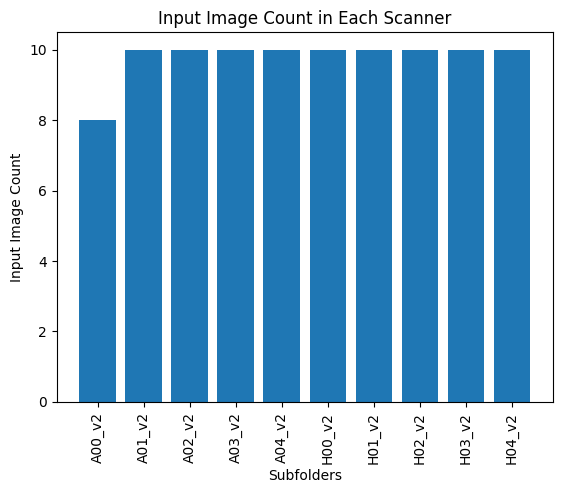

In [5]:
# Root folder path
root_folder = "/data1/vinod/mitosis/data/raw"  # Update this with the actual root folder path

# Dictionary to store subfolder names and image counts
subfolder_counts = {}

# Iterate over subfolders in the root folder
for subfolder_name in os.listdir(root_folder):
    subfolder_path = os.path.join(root_folder, subfolder_name)
    
    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        png_count = sum(1 for file in os.listdir(subfolder_path) if file.endswith(".png"))
        subfolder_counts[subfolder_name] = png_count

# Extract subfolder names and image counts for plotting
subfolder_names = list(subfolder_counts.keys())
image_counts = list(subfolder_counts.values())

# Plotting the bar chart
plt.bar(subfolder_names, image_counts)
plt.xlabel("Scanners")
plt.ylabel("Input Image Count")
plt.title("Input Image Count in Each Scanner")
plt.xticks(rotation=90)
plt.show()

In [12]:
import os
import shutil
import random
import math
import glob

root_folder = '/data1/vinod/mitosis/data/raw'
train_folder = '/data1/vinod/mitosis/data/processed/train'
val_folder = '/data1/vinod/mitosis/data/processed/val'

# Create train and val folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# Set the random seed
random_seed = 42
random.seed(random_seed)

# Get a list of all subfolders in the root folder
dest_subfolders = ['input', 'output', 'annotation', 'overlay']

for subfolder in dest_subfolders:
    # Create train and val subfolders
    train_subfolder = os.path.join(train_folder, subfolder)
    val_subfolder = os.path.join(val_folder, subfolder)
    os.makedirs(train_subfolder, exist_ok=True)
    os.makedirs(val_subfolder, exist_ok=True)

# Get a list of all subfolders in the root folder
subfolders = [f.path for f in os.scandir(root_folder) if f.is_dir()]

for subfolder in subfolders:

    # Get a list of all png files in the subfolder
    png_files = [file for file in glob.glob(os.path.join(subfolder, '*.png')) if not file.endswith('_mask.png')]

    # Calculate the number of files for training and validation
    num_files = len(png_files)
    num_train = math.ceil(0.8 * num_files)
    num_val = num_files - num_train

    # Shuffle the list of png files
    random.shuffle(png_files)

    # Copy files to train subfolder
    train_files = png_files[:num_train]
    for file in train_files:
        filename = os.path.basename(file)
        shutil.copy2(file[:-4] + '.png', os.path.join(train_folder, 'input', filename))
        shutil.copy2(file[:-4] + '_mask.png', os.path.join(train_folder, 'output', filename))
        shutil.copy2(file[:-4] + '.jpg', os.path.join(train_folder, 'overlay', filename))
        shutil.copy2(file[:-4] + '.csv', os.path.join(train_folder, 'annotation', filename[:-4] + '.csv'))

    # Copy files to val subfolder
    val_files = png_files[num_train:]
    for file in val_files:
        filename = os.path.basename(file)
        shutil.copy2(file[:-4] + '.png', os.path.join(val_folder, 'input', filename))
        shutil.copy2(file[:-4] + '_mask.png', os.path.join(val_folder, 'output', filename))
        shutil.copy2(file[:-4] + '.jpg', os.path.join(val_folder, 'overlay', filename))
        shutil.copy2(file[:-4] + '.csv', os.path.join(val_folder, 'annotation', filename[:-4] + '.csv'))


In [9]:
# Function to create a binary mask from coordinates
def create_binary_mask(image_size, coordinates):
    mask = np.zeros(image_size, dtype=np.uint8)
    for coord in coordinates:
        for i in range(0, len(coord), 2):
            x, y = coord[i], coord[i+1]
            mask[x, y] = 255
    return mask

In [3]:
# Path to the folder containing images
image_folder = "/data1/vinod/mitosis/data/raw/H03_v2"

# Path to the folder containing CSV files with coordinates
csv_folder = "/data1/vinod/mitosis/data/raw/H03_v2"

Binary mask created for H03_00.png.


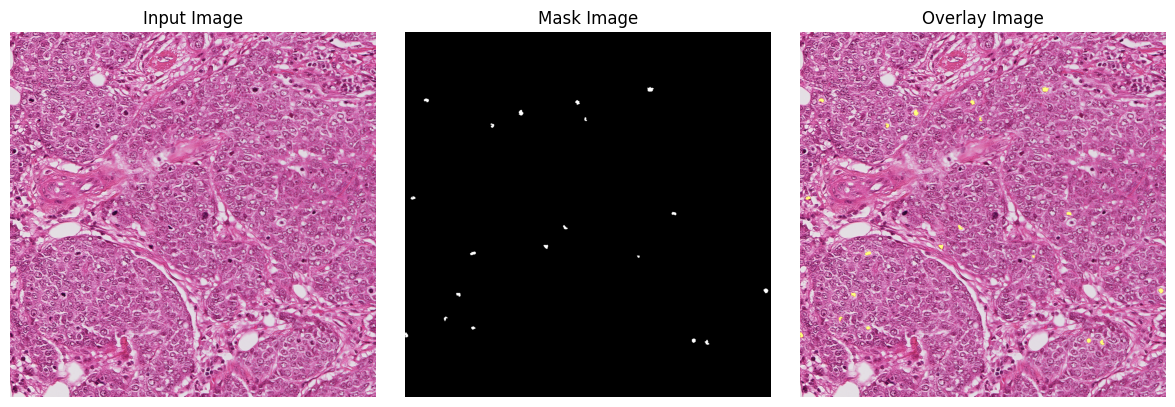

Binary mask created for H03_01.png.


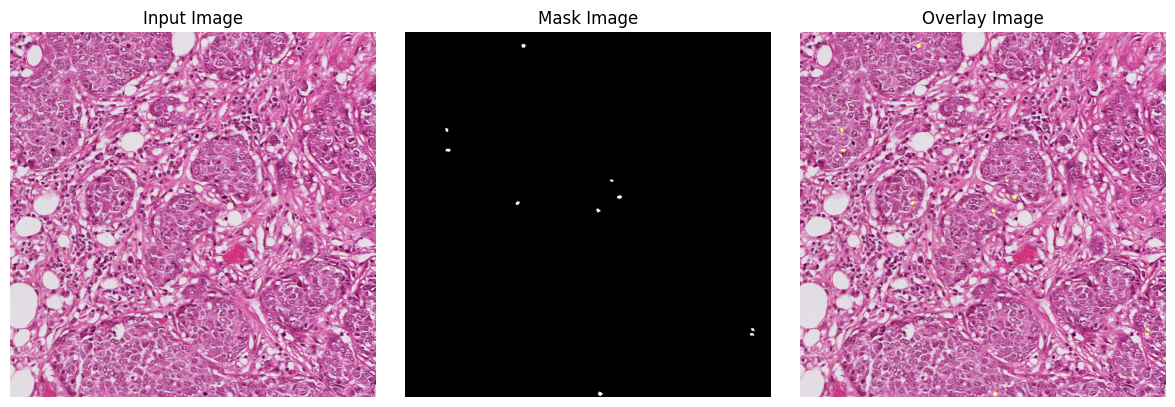

Binary mask created for H03_02.png.


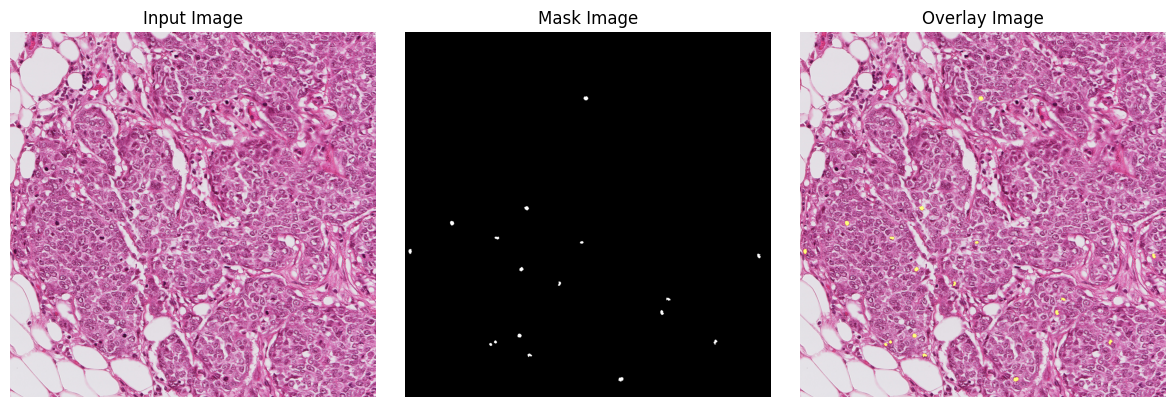

Binary mask created for H03_03.png.


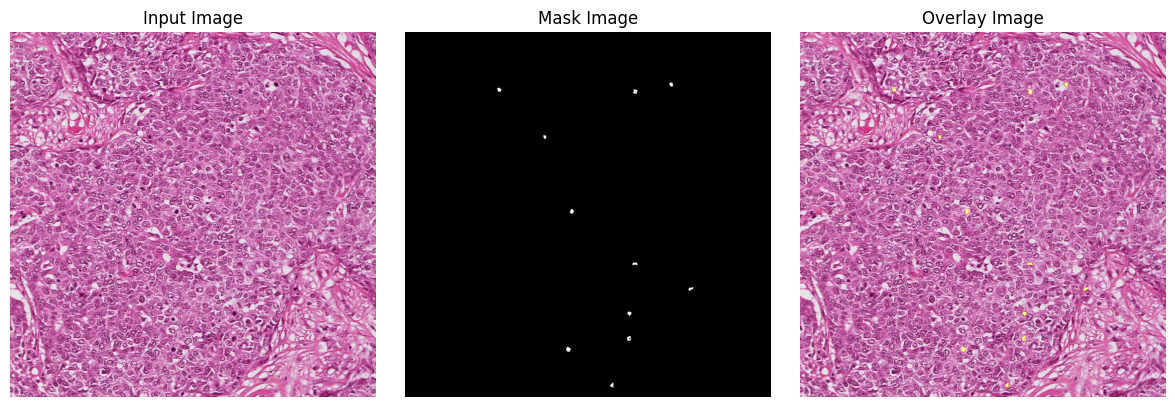

Binary mask created for H03_04.png.


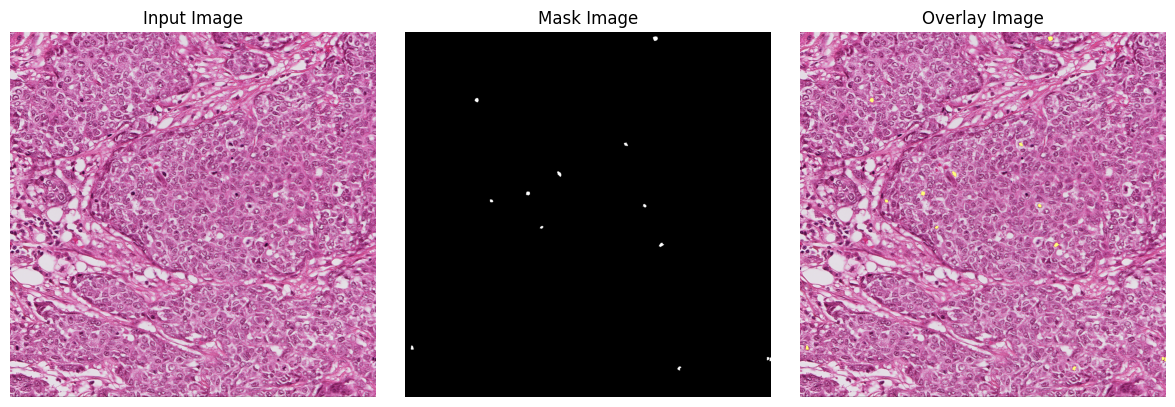

Binary mask created for H03_05.png.


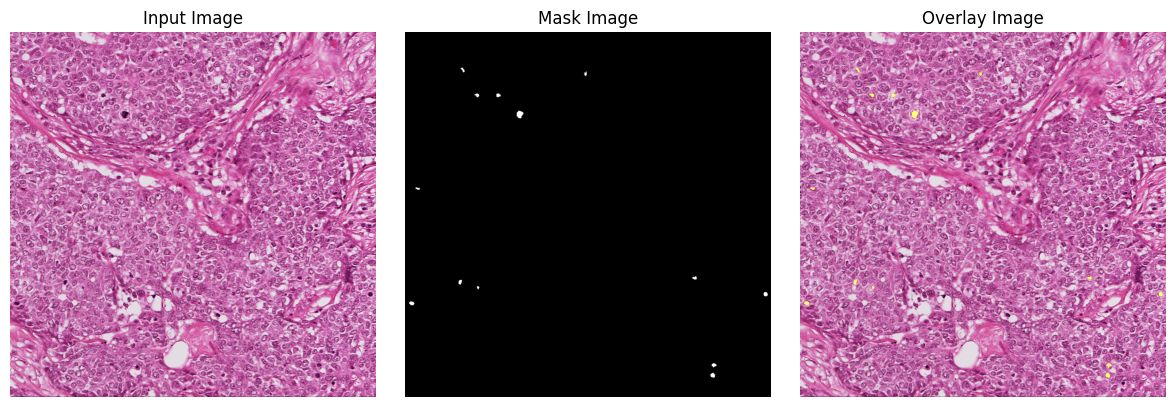

Binary mask created for H03_06.png.


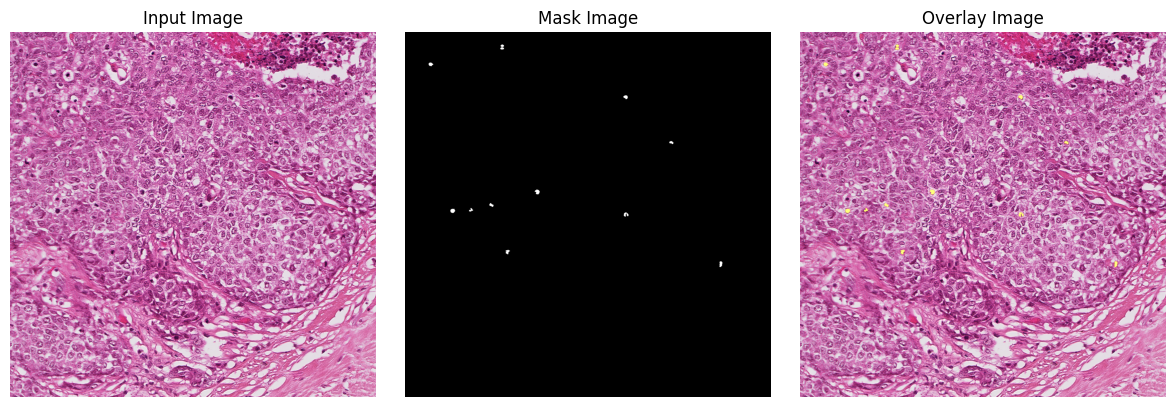

Binary mask created for H03_07.png.


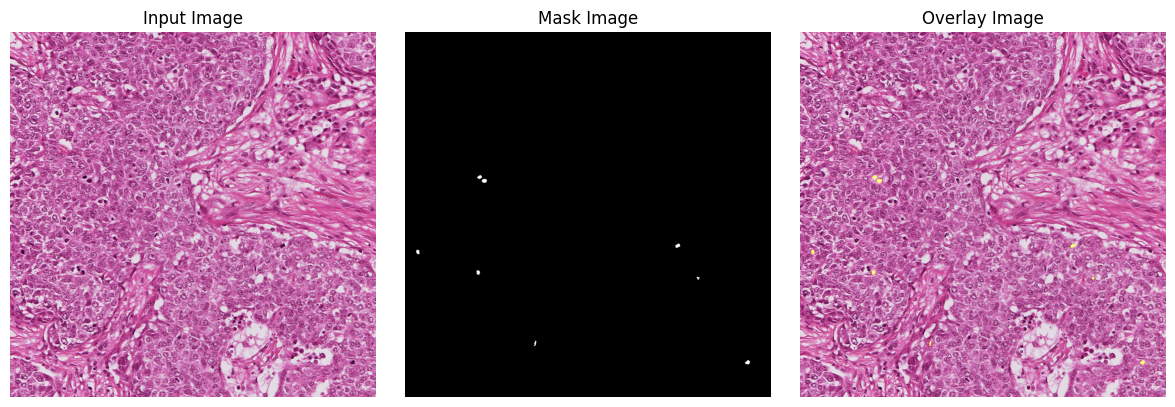

Binary mask created for H03_08.png.


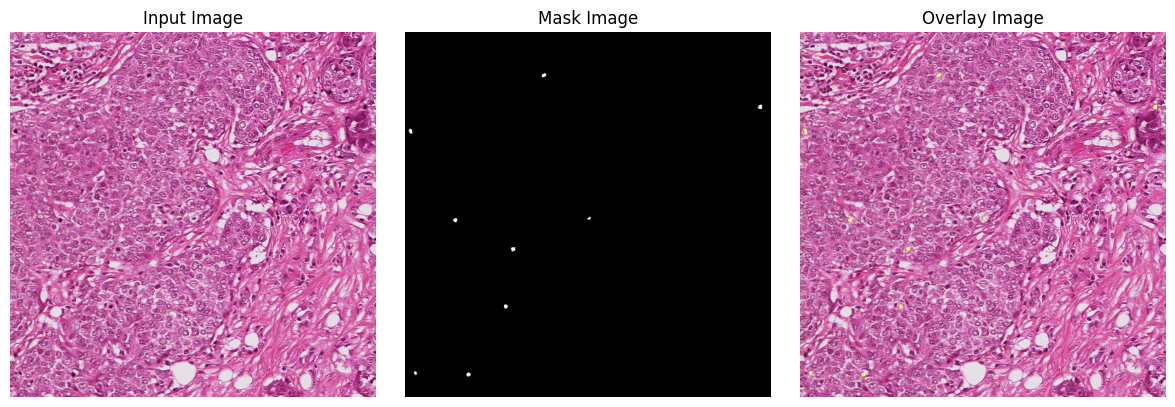

Binary mask created for H03_09.png.


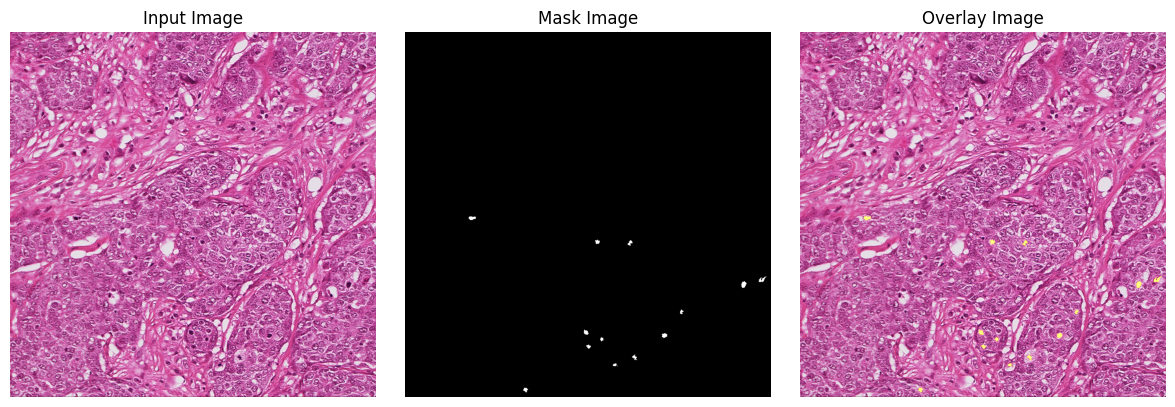

In [17]:
# Iterate over images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)

        # Load the image
        image = Image.open(image_path)
        image_size = image.size

        # Get the corresponding CSV file
        csv_filename = os.path.splitext(filename)[0] + ".csv"
        csv_path = os.path.join(csv_folder, csv_filename)
        # Check if the CSV file exists
        if os.path.exists(csv_path):
            # Read the CSV file and extract the coordinates
            coordinates = []
            with open(csv_path, 'r') as csv_file:
                csv_reader = csv.reader(csv_file)
                for row in csv_reader:
                    coordinates.append([int(coord) for coord in row])

            # Create the binary mask
            mask = create_binary_mask(image_size, coordinates)

            # Transpose the mask array
            mask = np.transpose(mask)

            # Save the mask as a binary image
            mask_image = Image.fromarray(mask, mode='L')
            mask_filename = os.path.splitext(filename)[0] + "_mask.png"
            mask_path = os.path.join(image_folder, 'mask', mask_filename)
            mask_image.save(mask_path)
            print(f"Binary mask created for {filename}.")

            # Create overlay image
            overlay = image.convert("RGBA")
            overlay_data = overlay.load()
            mask_data = mask_image.load()

            for i in range(overlay.size[0]):
                for j in range(overlay.size[1]):
                    if mask_data[i, j] > 0:
                        overlay_data[i, j] = (255, 255, 0, 128)  # Yellow color with transparency

            # Plot the images side by side
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(image)
            axs[0].set_title("Input Image")
            axs[0].axis("off")

            axs[1].imshow(mask_image, cmap="gray")
            axs[1].set_title("Mask Image")
            axs[1].axis("off")

            axs[2].imshow(overlay)
            axs[2].set_title("Overlay Image")
            axs[2].axis("off")

            plt.tight_layout()
            plt.show()

        else:
            print(f"CSV file not found for {filename}. Skipping.")


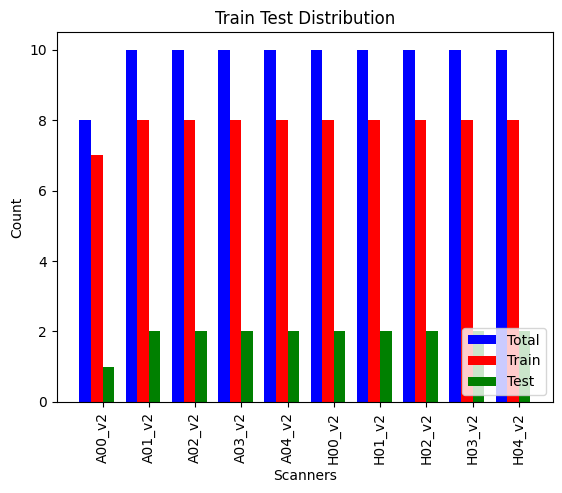

In [4]:
scores = ['Total', 'Train', 'Test']
group_names = ['A00_v2',
 'A01_v2',
 'A02_v2',
 'A03_v2',
 'A04_v2',
 'H00_v2',
 'H01_v2',
 'H02_v2',
 'H03_v2',
 'H04_v2']
group_values = [
    [8, 10, 10, 10, 10, 10, 10, 10, 10, 10],
    [7, 8, 8, 8, 8, 8, 8, 8, 8, 8],
    [1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
]
# Set the bar width
bar_width = 1.0 / (len(group_values) + 1)

# Set the x-axis values
x_axis = np.arange(len(group_names))

# Set the colors for each group
colors = ['blue', 'red', 'green']

# Create the bar chart
fig, ax = plt.subplots()
rects = []
for i in range(len(group_values)):
    offset = (i - len(group_values)/2) * bar_width
    rects.append(ax.bar(x_axis + offset, group_values[i], bar_width, color = colors[i], label= scores[i]))


# Add labels and title
ax.set_xlabel('Scanners')
ax.set_ylabel('Count')
ax.set_title('Train Test Distribution')
ax.set_xticks(x_axis)
ax.set_xticklabels(group_names)
ax.legend(loc='lower right')
plt.xticks(rotation=90)


# Display the chart
plt.show()